In [ ]:
import numpy as np

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1 Data

## Get the data

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-12-15 04:00:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2020-12-15 04:00:46 (282 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [ ]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

## Preprocess

In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [ ]:
sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

### view labels and sentences

In [ ]:
sentences[:4]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas']

In [ ]:
labels[:4]

[0, 0, 1, 1]

## Tokenizer and Pad Sequence

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

### view preprocessed sentences and labels

In [ ]:
training_padded[:1]

array([[328,   1, 799,   1,   1,  47, 389,   1,   1,   6,   1,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]], dtype=int32)

In [ ]:
training_labels[:1]

array([0])

# 2 Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)


# 3 Plot Accuracy and Loss

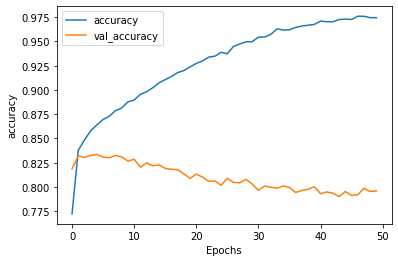

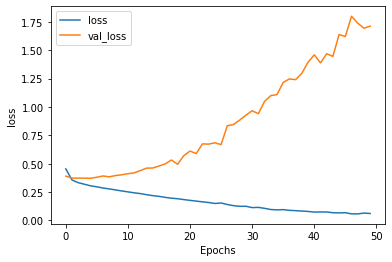

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
model.save("test.h5")

# 4 Testing

## own sentence

In [ ]:
test_sentence = "you worked for it. you deserve it well"

test_seq = tokenizer.texts_to_sequences([test_sentence])
testpad = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(testpad.shape)
model.predict(test_seq)

(1, 120)


array([[0.99428284]], dtype=float32)

## from test data

In [ ]:
model.predict(testing_padded[1].reshape(1,120))

array([[2.0693114e-13]], dtype=float32)

In [ ]:
testing_labels[1]

0